In [1]:
from models.lenet_models import LeNet1, LeNet4, LeNet5
from keras.layers import Input
from keras.datasets import mnist
from matplotlib import pyplot
import numpy as np

Using TensorFlow backend.


## Dataset (MNIST)

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [11]:
train_size = len(train_labels)
test_size = len(test_labels)
print("train size:", train_size, ",test size:", test_size)

train size: 60000 ,test size: 10000


7


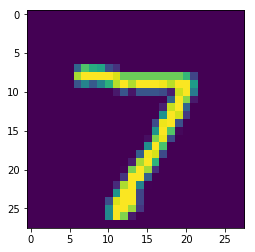

In [3]:
pyplot.imshow(test_images[0])
print(test_labels[0])

## Model (LeNet)

In [4]:
model = LeNet1(Input((28,28,1)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 4)         104       
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 14, 14, 4)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 12)        1212      
_________________________________________________________________
block2_pool1 (MaxPooling2D)  (None, 7, 7, 12)          0         
_________________________________________________________________
flatten (Flatten)            (None, 588)               0         
_________________________________________________________________
softmax (Dense)              (None, 10)                5890      
Total para

In [9]:
one_hot_prediction = model.predict(test_images[0].reshape(1,28,28,1))
prediction = one_hot_prediction.argmax(axis=-1)
print(prediction, one_hot_prediction)

[7] [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


## Testing DNN with Reinforcement Learning

### Input Selection

In [66]:
class CompleteTestSet:
    def __init__(self, initial_test_features, initial_test_labels):
        self.features = initial_test_features
        self.labels = initial_test_labels
        self.size = len(self.labels)
        self.weights = np.ones(self.size)
    
    def sample(self, batch_size):
        selected_indices = np.random.choice(self.size, size=batch_size, p=self.weights/np.sum(self.weights))
        return self.features[selected_indices], self.labels[selected_indices]
    
    def __call__(self, batch_size):
        return self.sample(batch_size)
    
    def __len__(self):
        return self.size
    
    def append(self, new_features, new_labels):
        new_size = len(new_labels)
        self.features = np.concatenate((self.features, new_features), axis=0)
        self.labels = np.concatenate((self.labels, new_labels), axis=0)
        self.weights = np.concatenate((self.weights, np.ones(new_size)), axis=0)
        self.size += new_size
        
    def increase_weights(self, indices, increase=1):
        self.weights[indices] += increase

In [67]:
testset = CompleteTestSet(test_images, test_labels)

In [68]:
testset.append([test_images[1]], [test_labels[1]])

In [69]:
len(testset)

10001

In [70]:
testset.increase_weights([10000], increase=100000)

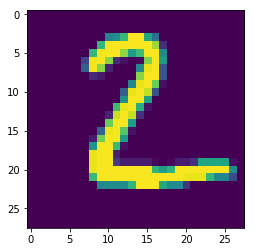

In [73]:
pyplot.imshow(testset.features[10000])

2


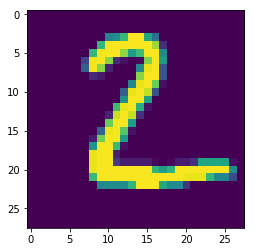

In [71]:
sample_image, sample_label = testset(1)
print(sample_label[0])
pyplot.imshow(sample_image[0])

### Mutator RL Agent

In [76]:
BATCH_SIZE = 8

#### State Space for RL Agent

* selected images: BATCH_SIZE * 28 * 28 * 1 
* current coverage state: ?

In [85]:
image_state = BATCH_SIZE * 28 * 28 * 1
coverage_state = 0
state_space = image_state + coverage_state
states = dict(type='float', shape=(state_space,))

#### Action Space for RL Agent

In [83]:
L_INFINITY = 30 # manually selected L_infinity distance limit for mutations

* number of pixel to change: BATCH_SIZE
* select pixels to change/select a permutation (first part of a selected permutation): BATCH_SIZE
* amount of change (max=L_INFINITY): BATCH_SIZE * 28 * 28 * 1 

In [110]:
action_space = BATCH_SIZE + BATCH_SIZE + (BATCH_SIZE * 28 * 28 * 1)
actions = dict(type='int', num_actions=action_space)

#### Neural Network which parameterizes RL Agent

In [111]:
rl_neural_net = [
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ]

#### RL Agent Definetion

In [112]:
from tensorforce.agents import PPOAgent

# Instantiate a Tensorforce agent
agent = PPOAgent(
    states=states,
    actions=actions,
    network=rl_neural_net,
    step_optimizer=dict(type='adam', learning_rate=1e-4)
)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
